# Vuelos y ventas a muelle

Este notebook une informacion de vuelos y ventas y genera un unico dataframe para todas las marcas.

## Librerias

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Any
import gc
import re

from unidecode import unidecode
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

import univariate_utils, multivariate_utils

## Constantes

In [2]:
CLEAN_FLIGHTS_FILE = "data/clean_flights.parquet"

In [3]:
CLEAN_SALES_FILE = "data/clean_sales.parquet"

In [4]:
MUELLE_FILE = "data/muelle.parquet"

## Utils

In [5]:
def clip_data_by_iqr(df, col, strategy, iqr_multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    bottom_limit = Q1 - iqr_multiplier * IQR
    top_limit = Q3 + iqr_multiplier * IQR
    
    is_low = df[col] <= bottom_limit
    is_high = df[col] >= top_limit
    
    if strategy == "bottom":
        df.loc[is_low, col] = bottom_limit
    if strategy == "top":
        df.loc[is_high, col] = top_limit
    else:
        df.loc[is_low, col] = bottom_limit
        df.loc[is_high, col] = top_limit

## Ejecucion

### Carga de dataframes

In [6]:
df_hourly_flights = pd.read_parquet(CLEAN_FLIGHTS_FILE)

In [7]:
df_sales = pd.read_parquet(CLEAN_SALES_FILE)

### Agrupacion de ventas por hora y muelle

In [8]:
df_hourly_sales = df_sales.groupby(
    ["muelle_venta", "fecha_venta", "hora_venta"]
).agg({
    "valor_venta": "sum"
}).reset_index(drop=False)

In [9]:
univariate_utils.make_not_graphic_analysis(df_hourly_sales)

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27346 entries, 0 to 27345
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   muelle_venta  27346 non-null  object 
 1   fecha_venta   27346 non-null  object 
 2   hora_venta    27346 non-null  float64
 3   valor_venta   27346 non-null  float64
dtypes: float64(2), object(2)
memory usage: 854.7+ KB
----- null percentage -----


muelle_venta    0.0
fecha_venta     0.0
hora_venta      0.0
valor_venta     0.0
dtype: float64

----- Object column statistics -----


,muelle_venta,fecha_venta
count,27346,27346
unique,2,611
top,muelle internacional oriente,2022-11-02
freq,14527,48


----- Number column statistics -----


,hora_venta,valor_venta
count,27346.000000,2.734600e+04
mean,11.887881,1.542236e+08
std,6.758483,1.019928e+08
min,0.000000,0.000000e+00
5%,1.000000,1.110446e+07
25%,6.000000,7.931948e+07
50%,12.000000,1.476627e+08
75%,18.000000,2.073627e+08
95%,22.000000,3.503475e+08
max,23.000000,6.898043e+08


----- First five rows -----


,muelle_venta,fecha_venta,hora_venta,valor_venta
0,muelle internacional centro,2022-01-01,6.0,183358175.1
1,muelle internacional centro,2022-01-01,7.0,173536525.2
2,muelle internacional centro,2022-01-01,8.0,100645418.2
3,muelle internacional centro,2022-01-01,9.0,63069457.7
4,muelle internacional centro,2022-01-01,10.0,135615274.1


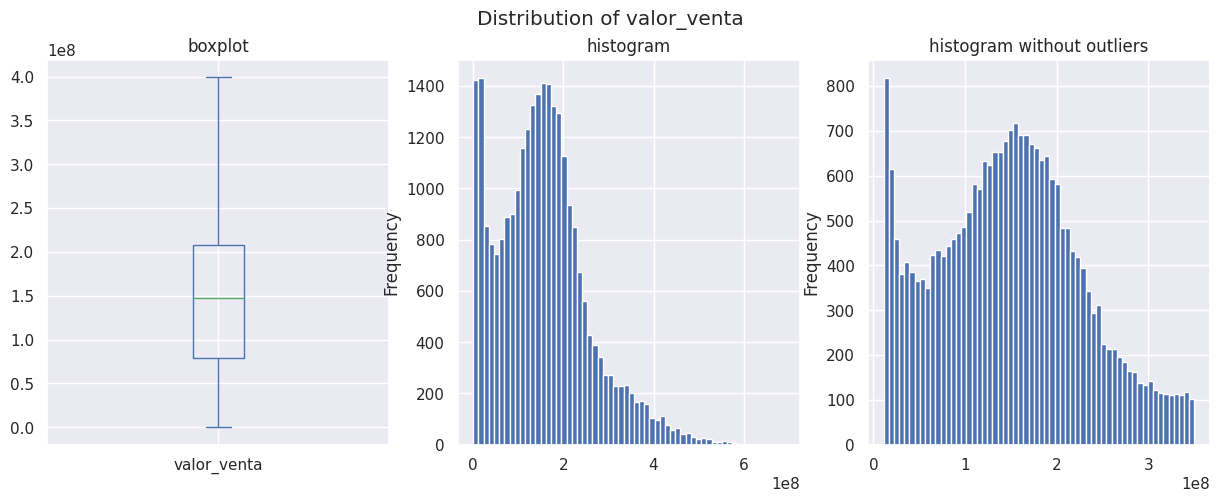

In [10]:
univariate_utils.plot_column_distribution(
        df_hourly_sales,
        "valor_venta",
        (15,5),
        60
    )

### Integracion de datos con datos de ventas

#### Seleccion de muelle (Dimension de relevancia)
El unico muelle en comun es muelle internacional oriente, asi que se toman los datos de este muelle y se hace una union entre vuelos y ventas agrupadas por hora con la condicion de que las ventas representan las ventas en las dos horas anteriores al vuelo.

In [11]:
df_hourly_sales["muelle_venta"].unique()

array(['muelle internacional centro', 'muelle internacional oriente'],
      dtype=object)

In [12]:
df_hourly_flights["Muelle"].unique()

array(['muelle internacional oriente', 'tpa', 'muelle nacional norte',
       'muelle nacional sur', 'muelle internacional occidente'],
      dtype=object)

In [13]:
df_hourly_sales = df_hourly_sales[
    df_hourly_sales["muelle_venta"] == "muelle internacional oriente"
]

In [14]:
df_hourly_flights = df_hourly_flights[
    df_hourly_flights["Muelle"] == "muelle internacional oriente"
]

#### Merge de dataframes
Se ignora la hora para poder operar la diferencia de 2 horas. Por otro lado se eliminan las filas con menos de 1% de nulos en hora de venta (dimension de completitud a nivel de atributo).

In [15]:
df_dataset = df_hourly_flights.merge(
    df_hourly_sales,
    left_on=["Muelle", "STD_date"],
    right_on=["muelle_venta", "fecha_venta"],
    how="left"
)

In [16]:
df_dataset.drop(
    columns=[
        "muelle_venta"
    ],
    inplace=True
)

In [17]:
df_dataset.isnull().sum()/len(df_dataset)

Destino                        0.000000
Tipo de vuelo                  0.000000
Sala                           0.000000
Muelle                         0.000000
FECHA DIA                      0.000000
AEROLÍNEA                      0.000000
Tipo aerolínea                 0.000000
STD                            0.000000
Pasajeros saliendo             0.000000
Hora entera                    0.000000
Semana                         0.000000
Mes                            0.000000
Día                            0.000000
Año                            0.000000
STD_date                       0.000000
Pasajeros por Muelle y Hora    0.000000
Porcentaje pasajeros vuelo     0.000000
fecha_venta                    0.016502
hora_venta                     0.016502
valor_venta                    0.016502
dtype: float64

In [18]:
df_dataset = df_dataset[
    ~df_dataset["hora_venta"].isnull()
].copy(deep=True)

In [19]:
df_dataset.isnull().sum()/len(df_dataset)

Destino                        0.0
Tipo de vuelo                  0.0
Sala                           0.0
Muelle                         0.0
FECHA DIA                      0.0
AEROLÍNEA                      0.0
Tipo aerolínea                 0.0
STD                            0.0
Pasajeros saliendo             0.0
Hora entera                    0.0
Semana                         0.0
Mes                            0.0
Día                            0.0
Año                            0.0
STD_date                       0.0
Pasajeros por Muelle y Hora    0.0
Porcentaje pasajeros vuelo     0.0
fecha_venta                    0.0
hora_venta                     0.0
valor_venta                    0.0
dtype: float64

#### Reintegrando timestamp de venta (dimension de conformidad)

Este formato es necesario para poder encontrar las horas de venta anteriores al vuelo.

In [20]:
df_dataset["timestamp_venta"] = (
    pd.to_datetime(df_dataset["fecha_venta"])
    + pd.to_timedelta(
        df_dataset["hora_venta"],
        unit="hours"
    )
)

#### Filtrado de ventas en las dos horas anteriores

In [21]:
df_dataset["STD"] = pd.to_datetime(df_dataset["STD"])
df_dataset["STD"]

37        2022-01-04 16:05:00
38        2022-01-04 16:05:00
39        2022-01-04 16:05:00
40        2022-01-04 16:05:00
41        2022-01-04 16:05:00
                  ...        
1232243   2022-10-07 08:00:00
1232244   2022-10-07 08:00:00
1232245   2022-10-07 08:00:00
1232246   2022-10-07 08:00:00
1232247   2022-10-07 08:00:00
Name: STD, Length: 1211913, dtype: datetime64[ns]

In [22]:
df_dataset["time_difference"] = (
    (df_dataset["STD"] - df_dataset["timestamp_venta"]).dt.seconds
    / float(3600)
)

In [23]:
is_sale_before_flight = (
    (df_dataset["time_difference"] <= 2.0)
    & (df_dataset["STD"] >= df_dataset["timestamp_venta"])
)

In [24]:
df_dataset = df_dataset[is_sale_before_flight].copy(deep=True)

#### Re agrupacion por hora y vuelo

Se evalua que no se generen valores anomalos al agrupar (dimension de conformidad a nivel de atributo)

In [25]:
df_dataset = df_dataset.groupby([
    "Destino",
    "Tipo de vuelo",
    "Sala",
    "Muelle",
    "AEROLÍNEA",
    "Tipo aerolínea",
    "STD",
    "Hora entera"
]).agg({
    "FECHA DIA": "min",
    "Pasajeros saliendo": "min",
    "Semana": "min",
    "Mes": "min",
    "Día": "min",
    "Año": "min",
    "Pasajeros por Muelle y Hora": "min",
    "Porcentaje pasajeros vuelo": "min",
    "valor_venta": "sum"
}).reset_index(drop=False)

In [26]:
univariate_utils.make_not_graphic_analysis(df_dataset)

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50775 entries, 0 to 50774
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Destino                      50775 non-null  object        
 1   Tipo de vuelo                50775 non-null  object        
 2   Sala                         50775 non-null  object        
 3   Muelle                       50775 non-null  object        
 4   AEROLÍNEA                    50775 non-null  object        
 5   Tipo aerolínea               50775 non-null  object        
 6   STD                          50775 non-null  datetime64[ns]
 7   Hora entera                  50775 non-null  int64         
 8   FECHA DIA                    50775 non-null  object        
 9   Pasajeros saliendo           50775 non-null  float64       
 10  Semana                       50775 non-null  int64         
 11  Mes             

Destino                        0.0
Tipo de vuelo                  0.0
Sala                           0.0
Muelle                         0.0
AEROLÍNEA                      0.0
Tipo aerolínea                 0.0
STD                            0.0
Hora entera                    0.0
FECHA DIA                      0.0
Pasajeros saliendo             0.0
Semana                         0.0
Mes                            0.0
Día                            0.0
Año                            0.0
Pasajeros por Muelle y Hora    0.0
Porcentaje pasajeros vuelo     0.0
valor_venta                    0.0
dtype: float64

----- Object column statistics -----


,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,FECHA DIA
count,50775,50775,50775,50775,50775,50775,50775
unique,62,1,19,1,39,4,7
top,miami,internacional,a8,muelle internacional oriente,avianca s a,legacy,lunes
freq,4697,50775,4575,50775,25233,42487,7468


----- Number column statistics -----


,Hora entera,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta
count,50775.000000,50775.000000,50775.000000,50775.000000,50775.000000,50775.000000,50775.000000,50775.000000,5.077500e+04
mean,12.349050,158.225593,23.578119,5.839783,15.713757,2022.428912,203.448154,0.880827,4.218181e+08
std,6.584188,48.284405,13.860344,3.172120,8.818710,0.494926,111.392579,0.236109,2.586768e+08
min,0.000000,0.000000,1.000000,1.000000,1.000000,2022.000000,0.000000,0.000000,0.000000e+00
5%,1.000000,92.000000,3.000000,1.000000,2.000000,2022.000000,96.000000,0.348128,2.221416e+07
25%,7.000000,125.000000,12.000000,3.000000,8.000000,2022.000000,132.000000,1.000000,2.504411e+08
50%,13.000000,153.000000,23.000000,6.000000,16.000000,2022.000000,166.000000,1.000000,4.086765e+08
75%,17.000000,180.000000,33.000000,8.000000,23.000000,2023.000000,250.000000,1.000000,5.974564e+08
95%,23.000000,261.500000,49.000000,12.000000,30.000000,2023.000000,440.000000,1.000000,8.610277e+08
max,23.000000,261.500000,52.000000,12.000000,31.000000,2023.000000,909.000000,1.000000,1.783547e+09


----- First five rows -----


,Destino,Tipo de vuelo,Sala,Muelle,AEROLÍNEA,Tipo aerolínea,STD,Hora entera,FECHA DIA,Pasajeros saliendo,Semana,Mes,Día,Año,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,valor_venta
0,amsterdam,internacional,a1,muelle internacional oriente,klm cia,legacy,2022-01-04 16:05:00,15,martes,124.0,1,1,4,2022,124.0,1.000000,363004768.5
1,amsterdam,internacional,a1,muelle internacional oriente,klm cia,legacy,2022-01-06 16:05:00,16,jueves,194.0,1,1,6,2022,370.0,0.524324,322837353.8
2,amsterdam,internacional,a1,muelle internacional oriente,klm cia,legacy,2022-01-14 16:05:00,16,viernes,217.0,2,1,14,2022,217.0,1.000000,169415437.8
3,amsterdam,internacional,a1,muelle internacional oriente,klm cia,legacy,2022-01-23 16:05:00,16,domingo,203.0,3,1,23,2022,341.0,0.595308,223725761.0
4,amsterdam,internacional,a1,muelle internacional oriente,klm cia,legacy,2022-02-07 16:35:00,16,lunes,204.0,6,2,7,2022,204.0,1.000000,367539969.4


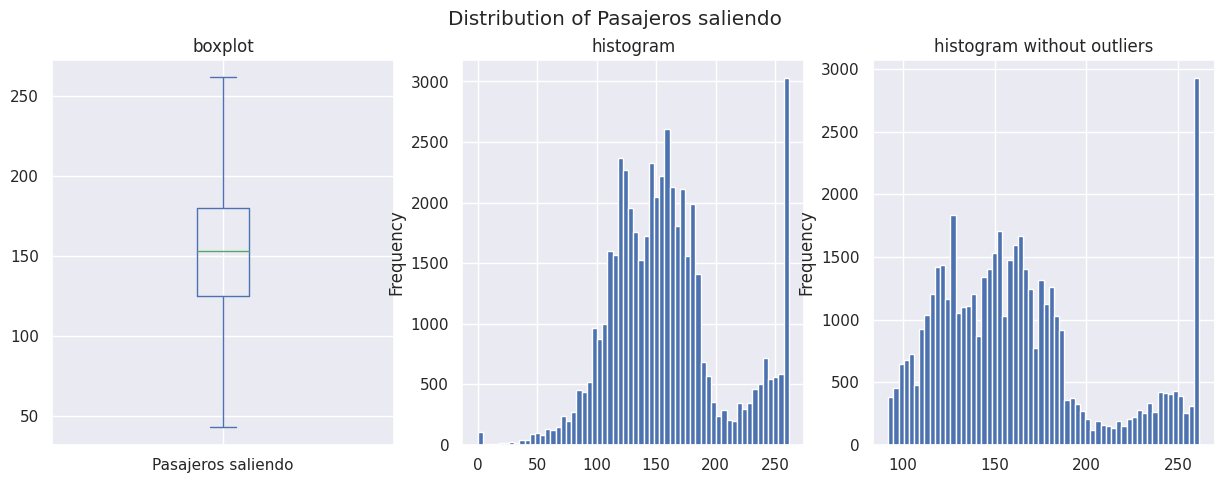

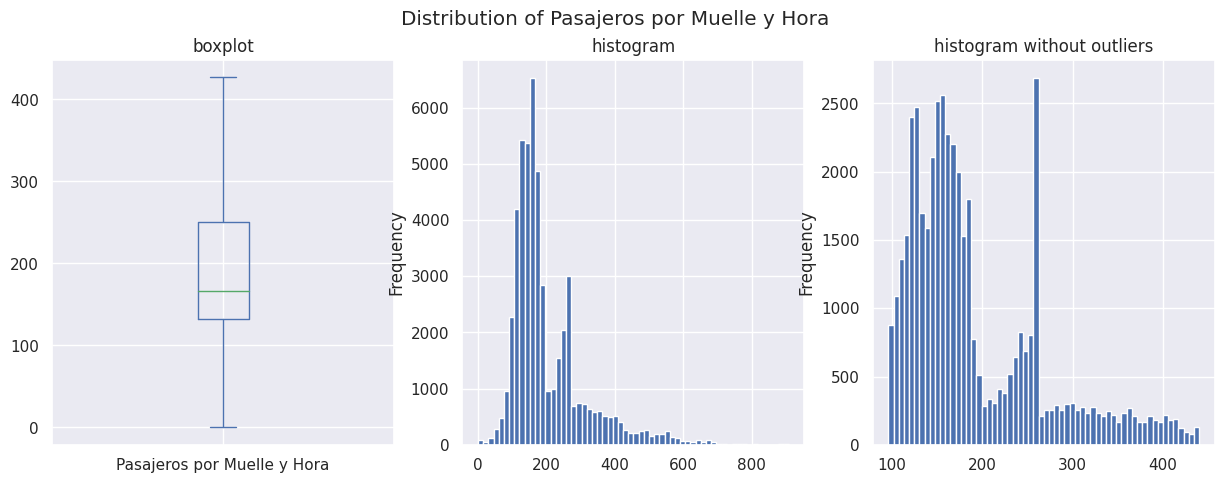

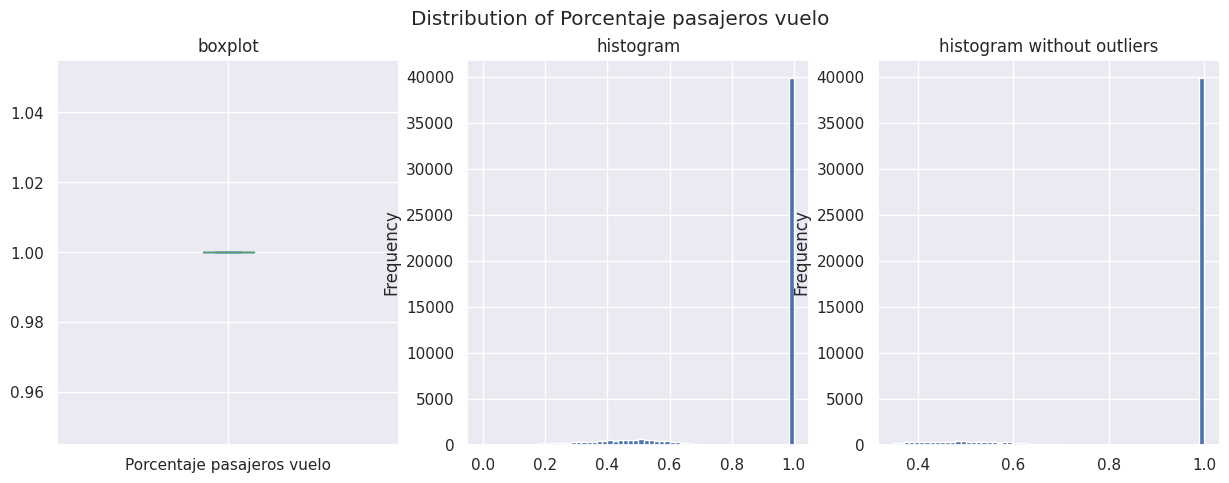

In [27]:
for col in ["Pasajeros saliendo", "Pasajeros por Muelle y Hora", "Porcentaje pasajeros vuelo"]:
    univariate_utils.plot_column_distribution(
        df_dataset,
        col,
        (15,5),
        60
    )

### Asignacion de valor de venta y transacciones generado por pasajeros de un vuelo
Se usa el porcentaje de pasajeros de ese vuelo sobre el total de pasajeros en una hora determinada para asignar el valor y transacciones de venta como el valor o transacciones de venta del muelle en esa hora multiplicado por el porcentaje de pasajeros correspondientes al vuelo en esa hora.

**NOTA: Se generan valores encima de mil millones para la ganancia horaria de un muelle, y estos valores estan confirmados numericamente con test individuales y sobre el excel. Esto implica que pueden haber anomalias en el registro de estos valores en el Excel**

Se hace clipping dados los valores extremos de Parte de valor_venta.

In [28]:
df_dataset["Parte de valor_venta"] = (
    df_dataset["valor_venta"]
    * df_dataset["Porcentaje pasajeros vuelo"]
).fillna(0.0)

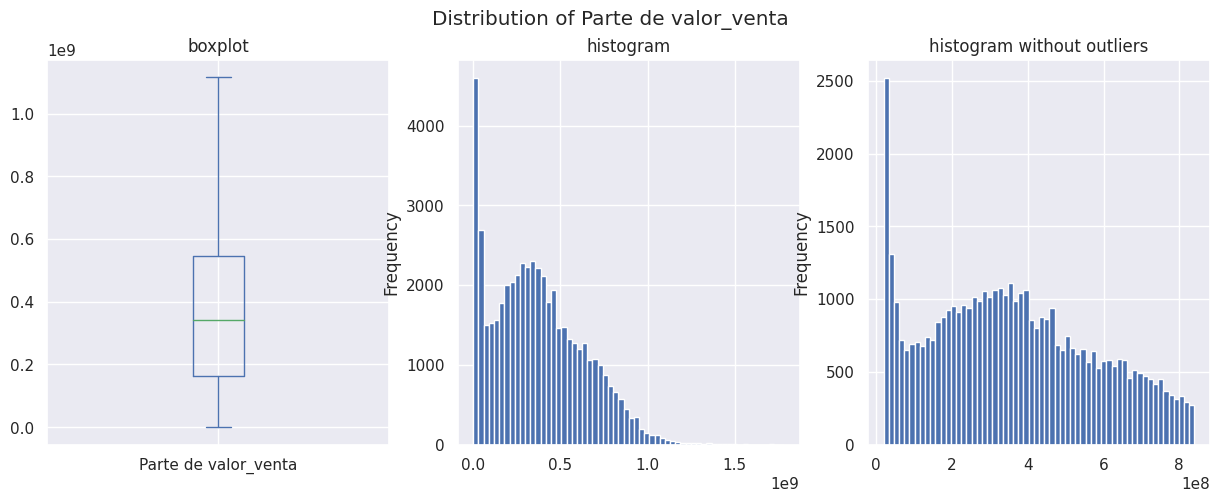

In [29]:
univariate_utils.plot_column_distribution(
    df_dataset,
    "Parte de valor_venta",
    (15,5),
    60
)

In [30]:
clip_data_by_iqr(df_dataset, "Parte de valor_venta", "top", 1.5)

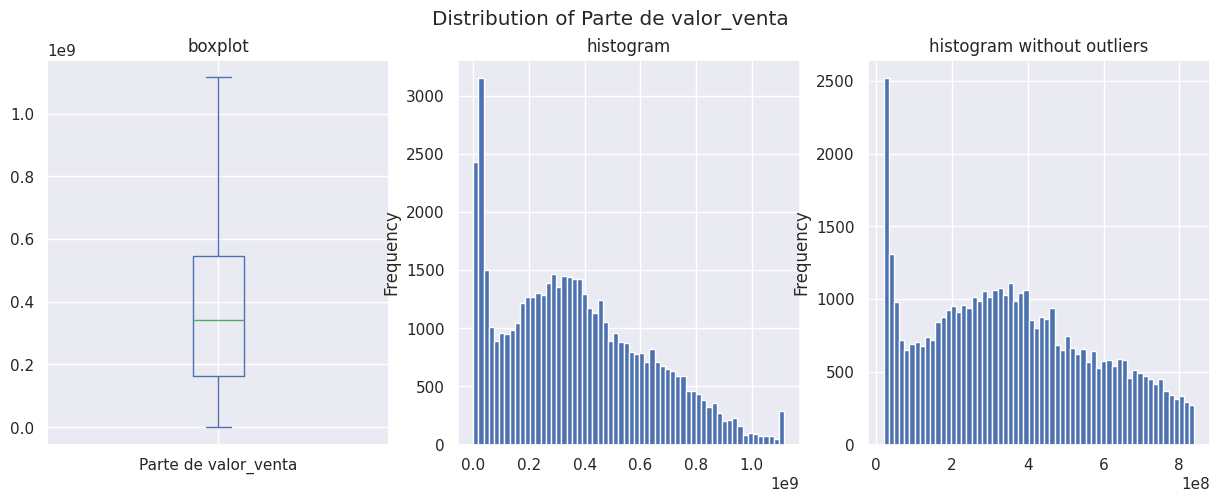

In [31]:
univariate_utils.plot_column_distribution(
    df_dataset,
    "Parte de valor_venta",
    (15,5),
    60
)

### Saving results to dataframe

In [32]:
df_dataset.to_parquet(MUELLE_FILE)